# Anomaly Analysis

## 1. Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading Data

In [3]:
data_1 = pd.read_csv('../data/Transactions/transactions_1.csv')

data_1.head()

,time,status,f0_
0,00h 00,approved,9
1,00h 00,denied,6
2,00h 00,refunded,1
3,00h 01,denied,8
4,00h 01,approved,13


In [4]:
data_2 = pd.read_csv('../data/Transactions/transactions_2.csv')

data_2.head()

,time,status,count
0,00h 00,reversed,7
1,00h 00,approved,9
2,00h 00,processing,12
3,00h 00,denied,3
4,00h 00,backend_reversed,2


## 3. Data Preprocessing

In [5]:
# Convert the 'time' column to datetime format
data_1['time'] = pd.to_datetime(data_1['time'], format='%Hh %M')
data_2['time'] = pd.to_datetime(data_2['time'], format='%Hh %M')

# Create a numeric column for status for machine learning model
data_1['status_num'] = data_1['status'].astype('category').cat.codes
data_2['status_num'] = data_2['status'].astype('category').cat.codes

In [7]:
data_1.head()

,time,status,f0_,status_num
0,1900-01-01 00:00:00,approved,9,0
1,1900-01-01 00:00:00,denied,6,2
2,1900-01-01 00:00:00,refunded,1,5
3,1900-01-01 00:01:00,denied,8,2
4,1900-01-01 00:01:00,approved,13,0


In [8]:
data_2.head()

,time,status,count,status_num
0,1900-01-01,reversed,7,6
1,1900-01-01,approved,9,0
2,1900-01-01,processing,12,4
3,1900-01-01,denied,3,2
4,1900-01-01,backend_reversed,2,1


## 4. Data Exploration

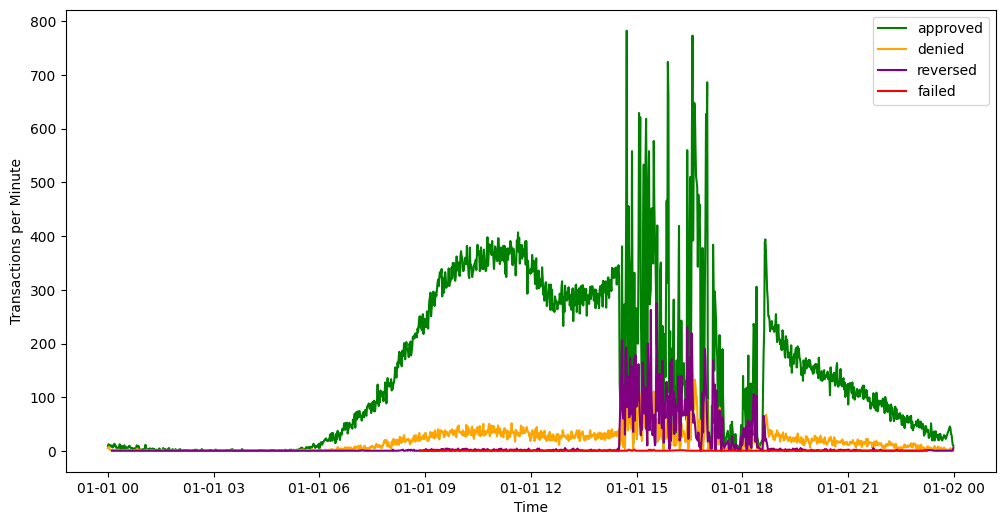

In [14]:
# Defining colors for status
colors = {'approved': 'green', 'denied': 'orange', 'failed': 'red', 'reversed': 'purple'}

# View transaction graph per minute for each status on data 1
plt.figure(figsize=(12, 6))
for status in data_1['status'].unique():
    if status in colors:
        plt.plot(data_1[data_1['status'] == status]['time'], 
                 data_1[data_1['status'] == status]['f0_'], 
                 label=status, 
                 color=colors[status])

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

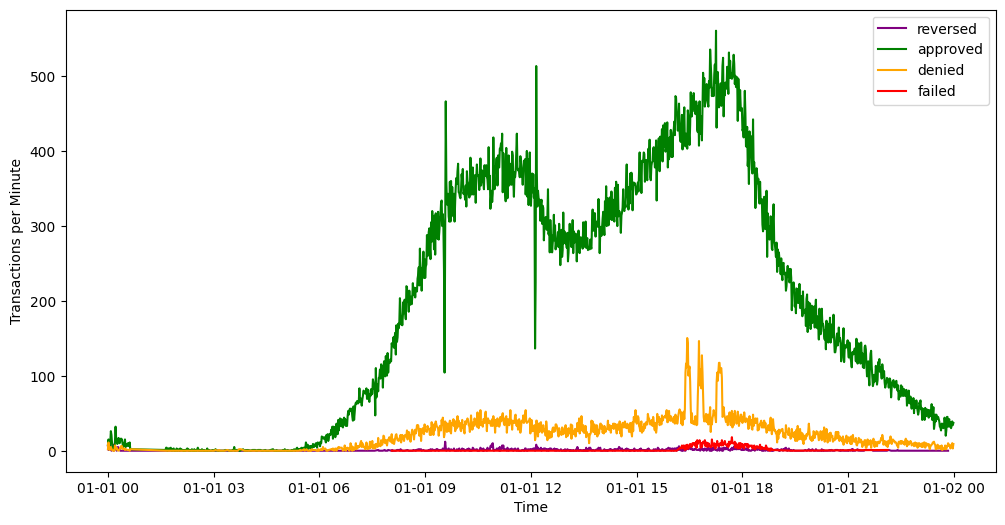

In [16]:
# View transaction graph per minute for each status on data 2
plt.figure(figsize=(12, 6))
for status in data_2['status'].unique():
    if status in colors:
        plt.plot(data_2[data_2['status'] == status]['time'], 
                 data_2[data_2['status'] == status]['count'], 
                 label=status, 
                 color=colors[status])

plt.xlabel('Time')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.show()

Let's evaluate the proportion for approved and other status

In [20]:
# Let's just organize data
pivoted_data_1 = data_1.pivot_table(index='time', columns='status', values='f0_', fill_value=0).reset_index()
pivoted_data_2 = data_2.pivot_table(index='time', columns='status', values='count', fill_value=0).reset_index()
pivoted_data_1.head()

status,time,approved,backend_reversed,denied,failed,processing,refunded,reversed
0,1900-01-01 00:00:00,9,0,6,0,0,1,0
1,1900-01-01 00:01:00,13,0,8,0,0,0,0
2,1900-01-01 00:02:00,11,0,7,0,0,1,0
3,1900-01-01 00:03:00,12,0,3,0,0,0,0
4,1900-01-01 00:04:00,11,0,0,0,0,0,0


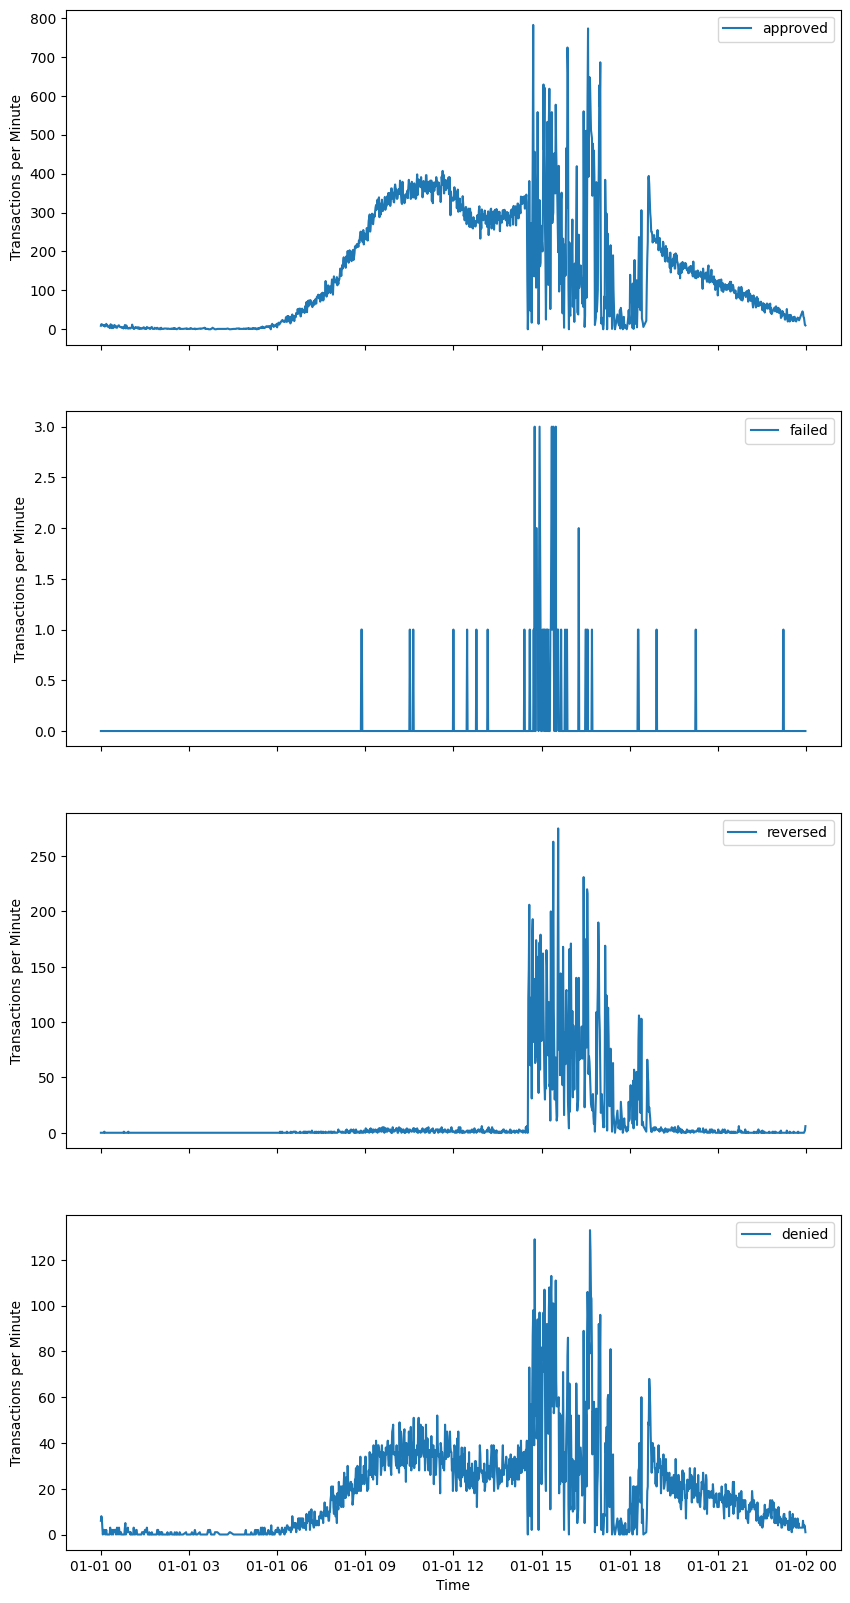

In [24]:
# Desired status to evaluate
desired_statuses = ['approved', 'failed', 'reversed', 'denied']

# Split graphics for each status in data 1
statuses = pivoted_data_1.columns[1:]

fig, axs = plt.subplots(len(desired_statuses), 1, figsize=(10, 5 * len(desired_statuses)), sharex=True)

for i, status in enumerate(desired_statuses):
    if status in statuses:
        axs[i].plot(pivoted_data_1['time'], pivoted_data_1[status], label=status)
        axs[i].set_ylabel('Transactions per Minute')
        axs[i].legend()

plt.xlabel('Time')
plt.show()

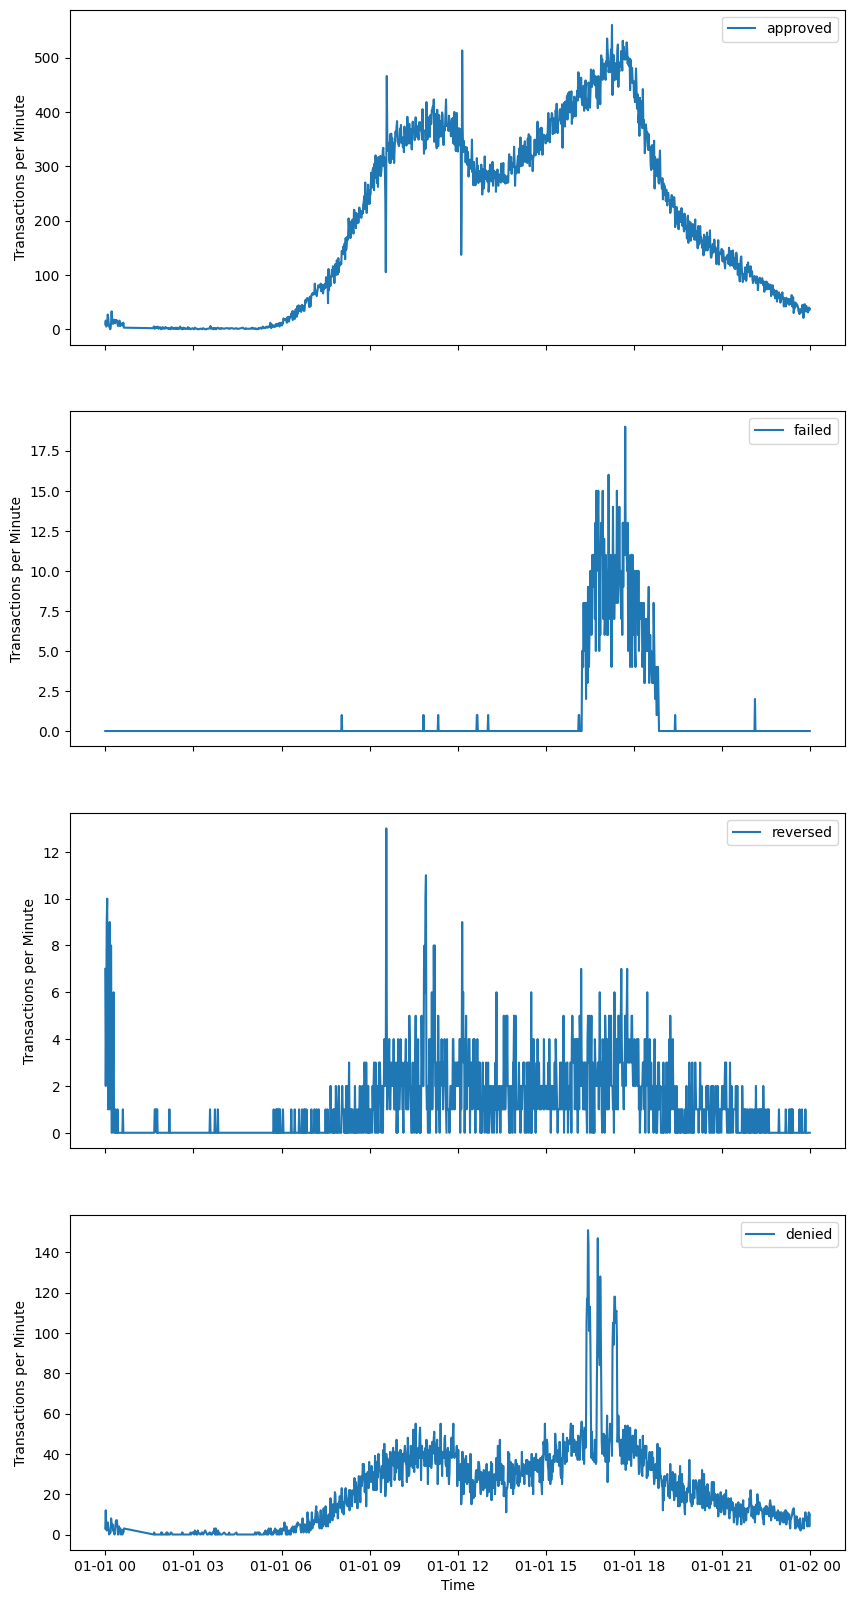

In [25]:
# Split graphics for each status in data 2
statuses = pivoted_data_2.columns[1:]

fig, axs = plt.subplots(len(desired_statuses), 1, figsize=(10, 5 * len(desired_statuses)), sharex=True)

for i, status in enumerate(desired_statuses):
    if status in statuses:
        axs[i].plot(pivoted_data_2['time'], pivoted_data_2[status], label=status)
        axs[i].set_ylabel('Transactions per Minute')
        axs[i].legend()

plt.xlabel('Time')
plt.show()

## 5. Conclusions

We can see that when the crash occurred, the indicator that represented well was the reversed one. As long as its value was above 6 for 3 minutes the anomaly was occurring. We can use this as a trigger for anomalies.

The denied indicator appears to grow along with approved transactions. Therefore, it is not a good numerical indicator for alerts. Let's try using a machine learning algo to detect anomalies from denied indicator.

The failed indicator seems to be common to appear at least 1 during the day, however when the failed indicator exceeds 1 during at least 2 minutes it raises suspicion of an anomaly.